### Dataset Description
The dataset contains bird images, divided into train and test splits. The images are inside test_images and train_images folders.

The labels of the training images are inside train_images.csv file. In this file, the first column is image_path and the second one is the label (1 - 200). The test_images_samples.csv includes a row id with a dummy label. The final goal of the challenge is to change the label column to the predicted label.

The class_names.npy is a dictionary including the name of each label. Load the file using the following code: np.load("class_names.npy", allow_pickle=True).item()

The structure of the final submission should be exactly the same as the test_images_samples.csv! Otherwise, it will fail.

Files

- train_images - the training images
- test_images - the test images
- test_images_sample.csv - a sample submission file in the correct format
- test_images_path.csv - path to test file images
- train_images.csv - supplemental information about the data
- class_names.npy - this file includes the name of each label
- attributes.npy - this file includes the attributes which are extra information for each class.
- attributes.txt - this file includes the attribute names which are extra information for each class.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

base_data_path = '/content/drive/MyDrive/UvA Data Science/AMS_feathers_in_focus-main'

#change gdrive wd
os.chdir(base_data_path)
print(f"wd changed to: {os.getcwd()}")

In [1]:
# Setup and imports
import numpy as np
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torchvision
import os


batch_size = 32
learning_rate = 0.0001
max_lr = 0.003
weight_decay = 0.0004
num_epochs = 100
num_classes = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
val_split = 0.2
seed = 42

torch.manual_seed(seed)
np.random.seed(seed)
print(device)

cuda


**Exploring class features**

In [ ]:
class_names = np.load("../class_names.npy", allow_pickle=True).item()
print(F"First class: {class_names}")
attributes = np.load("../attributes.npy", allow_pickle=True)
print(F"Attributes shape: {attributes.shape}")


First class: {np.str_('001.Black_footed_Albatross'): 1, np.str_('002.Laysan_Albatross'): 2, np.str_('003.Sooty_Albatross'): 3, np.str_('004.Groove_billed_Ani'): 4, np.str_('005.Crested_Auklet'): 5, np.str_('006.Least_Auklet'): 6, np.str_('007.Parakeet_Auklet'): 7, np.str_('008.Rhinoceros_Auklet'): 8, np.str_('009.Brewer_Blackbird'): 9, np.str_('010.Red_winged_Blackbird'): 10, np.str_('011.Rusty_Blackbird'): 11, np.str_('012.Yellow_headed_Blackbird'): 12, np.str_('013.Bobolink'): 13, np.str_('014.Indigo_Bunting'): 14, np.str_('015.Lazuli_Bunting'): 15, np.str_('016.Painted_Bunting'): 16, np.str_('017.Cardinal'): 17, np.str_('018.Spotted_Catbird'): 18, np.str_('019.Gray_Catbird'): 19, np.str_('020.Yellow_breasted_Chat'): 20, np.str_('021.Eastern_Towhee'): 21, np.str_('022.Chuck_will_Widow'): 22, np.str_('023.Brandt_Cormorant'): 23, np.str_('024.Red_faced_Cormorant'): 24, np.str_('025.Pelagic_Cormorant'): 25, np.str_('026.Bronzed_Cowbird'): 26, np.str_('027.Shiny_Cowbird'): 27, np.str_('0

### Setting up dataset and dataloaders
creating stratified train and validation set (80:20)

In [4]:
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset, Subset

torch.manual_seed(42)

class BirdDataset(Dataset):
    def __init__(self, csv_file, root_dir, img_col_idx, label_col_idx, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.img_col_idx = img_col_idx
        self.label_col_idx = label_col_idx
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        filename = str(self.data.iloc[idx, self.img_col_idx])
        clean_filename = filename.lstrip('/').lstrip('\\')
        img_path = os.path.join(self.root_dir, clean_filename)

        try:
            image = Image.open(img_path).convert('RGB')
        except (FileNotFoundError, OSError):
            print(f"Could not open {img_path}, using black image.")
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        # Raw CSV is 1-200. We subtract 1 to get 0-199 for PyTorch.
        raw_label = int(self.data.iloc[idx, self.label_col_idx])
        label = raw_label - 1

        # Transform
        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [14]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02),
    transforms.RandomAffine(
        degrees=15,
        translate=(0.1, 0.1),
        scale=(0.8, 1.2),
        shear=10
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.485, 0.456, 0.406),
        (0.229, 0.224, 0.225)
    ),
    transforms.RandomErasing(p=0.15)
])

#Validation
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [ ]:
from sklearn.model_selection import StratifiedKFold

full_train_dataset = BirdDataset('../train_images.csv', '../train_images/train_images', 0, 1, transform=train_transform)
full_val_dataset   = BirdDataset('../train_images.csv', '../train_images/train_images', 0, 1, transform=val_transform)

#lab -1 for CE Loss
labels = full_train_dataset.data.iloc[:, 1].values - 1

skf = StratifiedKFold(
    n_splits=int(1 / val_split),
    shuffle=True,
    random_state=seed
)

# Take the first fold
for train_idx, val_idx in skf.split(np.zeros(len(labels)), labels):
    break

train_dataset = Subset(full_train_dataset, train_idx)
val_dataset   = Subset(full_val_dataset,   val_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

print(f"Training set: {len(train_dataset)}")
print(f"Validation set: {len(val_dataset)}")

Training set: 3140
Validation set: 786


**Setting up test set**

In [ ]:
test_dataset  = BirdDataset('../test_images_path.csv', '../test_images', 1, 2, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Test set: {len(test_dataset)} images to predict.")

Test set: 4000 images to predict.


**Load a batch with labels for a manual check**

Labels in batch: [9, 91, 0, 118, 90, 46, 105, 36, 122, 163, 13, 158, 38, 24, 1, 7, 30, 146, 22, 173, 137, 97, 100, 23, 56, 93, 76, 34, 50, 23, 5, 148]


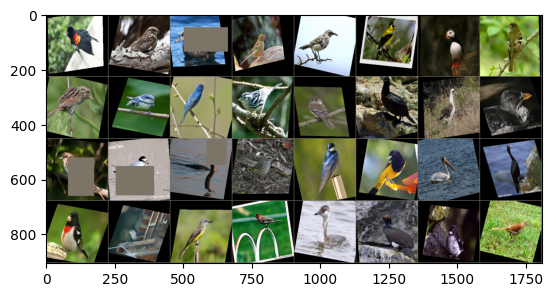

In [17]:
import matplotlib.pyplot as plt

def show_img(img):
    # Denormalize the image for proper display
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img * std + mean # de-normalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

print("Labels in batch:", labels.tolist())
show_img(torchvision.utils.make_grid(images, nrow = 8))

### Convolutional Neural Network

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class simpleCNN(nn.Module):
    def __init__(self, num_classes): #With num_classes already define the last layers output
        super().__init__()

        #first conv layer + pooling
        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 16, kernel_size= 3, padding= 1) #224/3 leaves 1 padding
        self.pool = nn.MaxPool2d(kernel_size=2, stride = 2) #halves dims

        #second conv layer, add pooling in forward func
        self.conv2 = nn.Conv2d(in_channels= 16, out_channels= 32, kernel_size=3, padding = 1)

        #third conv layer, add pooling in forward func
        self.conv3 = nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size=3, padding= 1)

        #make linear
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

        #maybe add dropout if overfitting
    def forward(self, x):
        #conv > relu > pool
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, 64 * 28 * 28) #-1 lets numpy change to needed number

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [19]:
import torch.optim as optim

num_classes = len(class_names)
model = simpleCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)


In [21]:
n_epoch = 40

for epoch in range(n_epoch):
    #train
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    #val
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100.0 * correct / total

    print(
        f"Epoch {epoch+1}/{n_epoch}, "
        f"Train loss: {avg_train_loss:.3f}, "
        f"Val loss: {avg_val_loss:.3f}, "
        f"Val acc: {val_acc:.1f}%"
    )


Epoch 1/40, Train loss: 4.030, Val loss: 4.569, Val acc: 9.9%
Epoch 2/40, Train loss: 3.960, Val loss: 4.447, Val acc: 10.8%
Epoch 3/40, Train loss: 3.859, Val loss: 4.478, Val acc: 8.3%
Epoch 4/40, Train loss: 3.773, Val loss: 4.546, Val acc: 9.7%
Epoch 5/40, Train loss: 3.645, Val loss: 4.476, Val acc: 9.9%
Epoch 6/40, Train loss: 3.508, Val loss: 4.546, Val acc: 11.6%
Epoch 7/40, Train loss: 3.456, Val loss: 4.595, Val acc: 10.6%
Epoch 8/40, Train loss: 3.370, Val loss: 4.781, Val acc: 12.1%
Epoch 9/40, Train loss: 3.256, Val loss: 4.793, Val acc: 11.1%
Epoch 10/40, Train loss: 3.171, Val loss: 4.627, Val acc: 11.1%
Epoch 11/40, Train loss: 3.086, Val loss: 4.769, Val acc: 10.7%
Epoch 12/40, Train loss: 3.037, Val loss: 4.875, Val acc: 12.6%
Epoch 13/40, Train loss: 2.948, Val loss: 4.824, Val acc: 12.7%
Epoch 14/40, Train loss: 2.905, Val loss: 4.896, Val acc: 11.7%
Epoch 15/40, Train loss: 2.842, Val loss: 4.982, Val acc: 11.8%
Epoch 16/40, Train loss: 2.745, Val loss: 5.072, Val 

In [ ]:
from pathlib import Path
path= '../Models/simpleCNN.pth'
torch.save(model.state_dict(), path)

In [ ]:
model.eval()
all_predictions = []

with torch.no_grad(): # Don't calculate gradients
    for images, _ in test_loader:
        images = images.to(device)

        # Forward pass
        outputs = model(images)

        # Get the class with the highest probability
        _, predicted = torch.max(outputs.data, 1)

        all_predictions.extend(predicted.cpu().numpy())

submission = pd.read_csv('../test_images_sample.csv')

# is length correct
if len(submission) != len(all_predictions):
    print(f"Sample has {len(submission)} rows but predicted {len(all_predictions)}")

# Add 1 because subtracted 1 in the Dataset class
submission['label'] = [p + 1 for p in all_predictions]

submission.to_csv('../Submission_csv/submission.csv', index=False)
print("submission.csv saved")